In [6]:
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import pandas as pd
from scientific_python_utils.geospatial import ensure_projected_CRS

from pathlib import Path

In [ ]:
GEOSPATIAL_MAPS_FOLDER = Path("/ofo-share/scratch-david/NRS-all-sites/geospatial_maps")
SHIFT_PER_DATASET = "/ofo-share/repos-david/UCNRS-experiments/data/shift_per_dataset.json"
METADATA_FILE = "/ofo-share/drone-imagery-organization/3c_metadata-extracted/all-mission-polygons-w-metadata.gpkg"
OUTPUT_FILE = "/ofo-share/repos-david/UCNRS-experiments/data/all_geospatial_maps_merged.geojson"

# Simplify the geometry such that the maximum deviation never exceeds this amount
SIMPLIFY_TOL = 0.1
VIS = True

In [8]:
missions_metadata = gpd.read_file(METADATA_FILE)

Reading /ofo-share/scratch-david/NRS-all-sites/geospatial_maps/000547.geojson


/ofo-share/repos-david/conda/envs/GDRT/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tmp/ipykernel_13657/2992344746.py:41: UserWarning: keep_geom_type can not be called on a GeoDataFrame with GeometryCollection.
  gdf = gpd.clip(gdf=gdf, mask=mission_polygon, keep_geom_type=True)


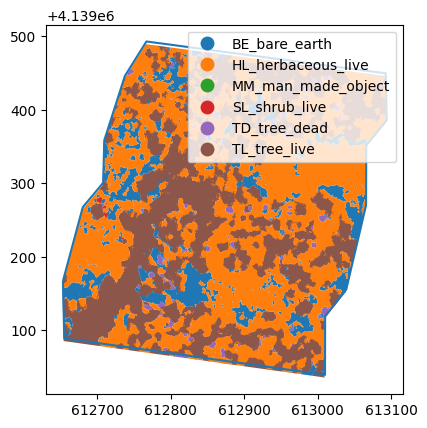

Reading /ofo-share/scratch-david/NRS-all-sites/geospatial_maps/000548.geojson


/ofo-share/repos-david/conda/envs/GDRT/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tmp/ipykernel_13657/2992344746.py:41: UserWarning: keep_geom_type can not be called on a GeoDataFrame with GeometryCollection.
  gdf = gpd.clip(gdf=gdf, mask=mission_polygon, keep_geom_type=True)


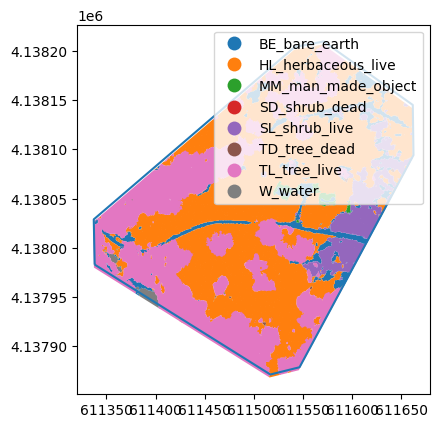

Reading /ofo-share/scratch-david/NRS-all-sites/geospatial_maps/000549.geojson


/ofo-share/repos-david/conda/envs/GDRT/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tmp/ipykernel_13657/2992344746.py:41: UserWarning: keep_geom_type can not be called on a GeoDataFrame with GeometryCollection.
  gdf = gpd.clip(gdf=gdf, mask=mission_polygon, keep_geom_type=True)


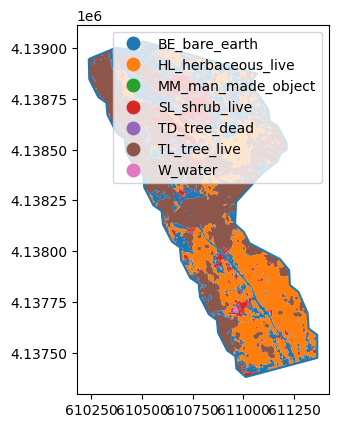

In [ ]:
from IPython.core.debugger import set_trace
# List all the files that are present
map_files = sorted(GEOSPATIAL_MAPS_FOLDER.glob("*"))[3:6]

# Open the list of shifts for each dataset
with open(SHIFT_PER_DATASET, "r") as infile:
    shifts_per_dataset = json.load(infile)

# Iterate over all datasets. Read them and post-process the results
all_dataframes = []
for map_file in map_files:
    mission_id = map_file.stem

    if mission_id not in shifts_per_dataset:
        print(f"Mission ID {mission_id} not in shifts_per_dataset. Skipping.")
        continue

    # Try to read the dataset from disk
    print(f"Reading {map_file}")
    try:
        gdf = gpd.read_file(map_file)
    except:
        print(f"Failed to read {mission_id}. Skipping")
        continue

    # Make sure this is in a projected CRS so geometric operations work as expected
    gdf = ensure_projected_CRS(gdf)
    # Simplify the geometry to make future operations faster
    gdf.geometry = gdf.simplify(SIMPLIFY_TOL)
    # Make sure the geometry is valid. This is especially important because this data is generated
    # from the projection of the mesh.
    gdf.geometry = gdf.make_valid()
    # Add a dataset identifier
    gdf["mission_id"] = mission_id

    # Extract the corresponding mission-level metadata which contains the bounding flight polygon
    metadata_for_mission = missions_metadata[missions_metadata.mission_id == mission_id]
    # Make the CRS for the flight polygon match that of the prediction
    metadata_for_mission.to_crs(gdf.crs, inplace=True)
    # Extract the actual polygon element
    mission_polygon = metadata_for_mission.geometry.values[0]

    # Clip the prediction to the extent of the mission polygon
    gdf = gpd.clip(gdf=gdf, mask=mission_polygon, keep_geom_type=True)

    # Get the x, y shift for this dataset
    shift = shifts_per_dataset[mission_id]
    # Apply this shift. Note it's important this happens after the crop occurs since the flight
    # polygon is relative to the input data, not absolute.
    gdf.geometry = gdf.translate(xoff=shift[0], yoff=shift[1])

    # Visualize if requested
    if VIS:
        f, ax = plt.subplots()
        metadata_for_mission.boundary.plot(ax=ax)
        gdf.plot("class_names", legend=True, vmin=-0.5, vmax=9.5, ax=ax)
        plt.show()

    all_dataframes.append(gdf)


In [15]:
merged_dataframes = pd.concat(all_dataframes)
print(merged_dataframes)

   class_ID         class_names  \
4       5.0        TD_tree_dead   
5       6.0        TL_tree_live   
2       2.0  MM_man_made_object   
0       0.0       BE_bare_earth   
1       1.0  HL_herbaceous_live   
3       4.0       SL_shrub_live   
7       7.0             W_water   
5       5.0        TD_tree_dead   
0       0.0       BE_bare_earth   
1       1.0  HL_herbaceous_live   
6       6.0        TL_tree_live   
4       4.0       SL_shrub_live   
3       3.0       SD_shrub_dead   
2       2.0  MM_man_made_object   
7       7.0             W_water   
6       6.0        TL_tree_live   
2       2.0  MM_man_made_object   
0       0.0       BE_bare_earth   
4       4.0       SL_shrub_live   
5       5.0        TD_tree_dead   
1       1.0  HL_herbaceous_live   

                                            geometry mission_id  
4  MULTIPOLYGON (((612768.748 4139134.521, 612769...     000547  
5  MULTIPOLYGON (((612739.048 4139082.221, 612739...     000547  
2  MULTIPOLYGON (((612890.698 4

In [17]:
merged_dataframes.to_file(OUTPUT_FILE)
print("done")

done
